## Numba performance evaluation

reference: https://numba.pydata.org/numba-doc/latest/user/performance-tips.html#performance-tips

`conda install numba`

In [1]:
import math
from collections import defaultdict
from timeit import repeat

import dask.array as da
import numba as nb
import numpy as np
import pandas as pd
from tqdm import tqdm

jit, prange = nb.jit, nb.prange
pd.set_option("display.max_columns", 50)
pd.set_option("max_colwidth", 100)
pd.set_option("display.width", 250)

def logrange(beg: int, end: int, num: int = 0, ratio: int = 1):
    beg, end = math.log2(beg), math.log2(end)
    num = ratio * (end - beg) + 1 if num == 0 else num
    r = np.logspace(beg, end, num=num, base=2.0)
    return r.round().astype(int)

n2pow = lambda n: f"2^{int(math.log2(n))}"
pow2n = lambda n: int(n.split("^")[0]) ** int(n.split("^")[1])

### Functions (accumulate a transcendental)

In [5]:
# numpy
sum_accumulate_np = lambda samples: np.log1p(samples).sum()
sum_accumulate_np.__name__ = "sum_accumulate_np"


# dask
sum_accumulate_dask = lambda samples: da.log1p(samples).sum().compute()
sum_accumulate_dask.__name__ = "sum_accumulate_dask"


# regular python
def sum_accumulate_python(samples: np.ndarray) -> float:
    t = 0.0
    for s in samples.tolist():
        t += math.log1p(s)
    return t


# numba with fast math approximations
@jit(nopython=True, fastmath=True)
def sum_accumulate_numba(samples: np.ndarray) -> np.float64:
    t = np.float64(0.0)
    for s in samples:
        t += math.log1p(s)
    return t


# numba with parallel and fast
@jit(nopython=True, parallel=True, fastmath=True)
def sum_accumulate_numba_parallel(samples: np.ndarray) -> np.float64:
    t = np.float64(0.0)
    for i in prange(samples.size):
        t += math.log1p(samples[i])
    return t


funcs_to_eval = [
    sum_accumulate_python,
    sum_accumulate_np,
    sum_accumulate_dask,
    sum_accumulate_numba,
    sum_accumulate_numba_parallel,
]


# cupy requires cuda and nvidia gpu
try:
    import cupy as cp

    # cupy gpu kernel
    def sum_accumulate_cupy(samples: cp.ndarray) -> cp.ndarray:
        return cp.log1p(samples).sum()

    funcs_to_eval.append(sum_accumulate_cupy)
except Exception as e:
    print("cupy did not load")
    cp = np

### Benchmark

In [10]:
get_samples = lambda f: "samp_cp" if "cupy" in f.__name__ else "samp_da" if "dask" in f.__name__ else "samples"
order_n = lambda n: f"2^{math.log2(n) // 10 * 10:0g}"
m, nn = 2 ** 10, 2 ** 30
samples = np.arange(1, m, dtype=np.float64)
samp_cp = cp.arange(1, m, dtype=cp.float64)

# execute the numba functions once so that they can compile
[func(samples) for func in funcs_to_eval if "numba" in func.__name__]
[func(samp_cp) for func in funcs_to_eval if "cp" in func.__name__]

# timer
num, rpt = 1, 5
benchargs = {"repeat": rpt, "number": num, "globals": globals()}
name = lambda func: func.__name__
name_short = lambda n: n.split("sum_accumulate_")[1] if n.startswith("sum") else n
my_timer = lambda func, data: repeat(f"{name(func)}({data})", **benchargs)

In [4]:
# eval
results = defaultdict(list)
stop = defaultdict(bool)
stop_th = 2.0 # seconds

for n in tqdm(logrange(m, nn)):
    samples, samp_cp, samp_da = np.arange(1, n, dtype=np.float64), cp.arange(1, n, dtype=cp.float32), da.arange(1, n, chunks=2**20, dtype=np.float64)
    results["n"] += [n for _ in range(rpt)]
    results["iter"] += [i for i in range(rpt)]
    results["order"] += [order_n(n) for _ in range(rpt)]
    for func in funcs_to_eval:
        if stop[func]:
            results[name(func)] += [np.inf for _ in range(rpt)]
        else:
            r = my_timer(func, get_samples(func))
            results[name(func)] += r
            if r[0] > stop_th:
                stop[func] = True

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [02:10<00:00, 23.65s/it]


### Results

In [5]:
results_fmt = {name_short(k): v for k, v in results.items()}

# tidy form
df = (
    (pd.DataFrame(results_fmt).set_index(["n", "order", "iter"]) * 1e3)
    .round(4)
    .stack()
    .reset_index()
    .rename(columns={"level_3": "func", 0: "time (ms)"})
)
df["n (samples)"] = df.n.apply(lambda x: n2pow(x))
df["device"] = ["gpu" if "gpu" in f or "cupy" in f else "purepy" if "python" in f else "cpu" for f in df.func]

# plot df
pdf = (
    df
    .applymap(lambda x: math.log2(x) if isinstance(x, float) else x)
    .rename(columns={"time (ms)": "time (log ms)"})
)
pdf.loc[:, "time (log ms)"] = pdf["time (log ms)"] + abs(pdf["time (log ms)"].min())

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sel_palette = lambda df, c: sns.color_palette("hls", df[c].nunique(), desat=0.95)
plt.show()
e = "mean"

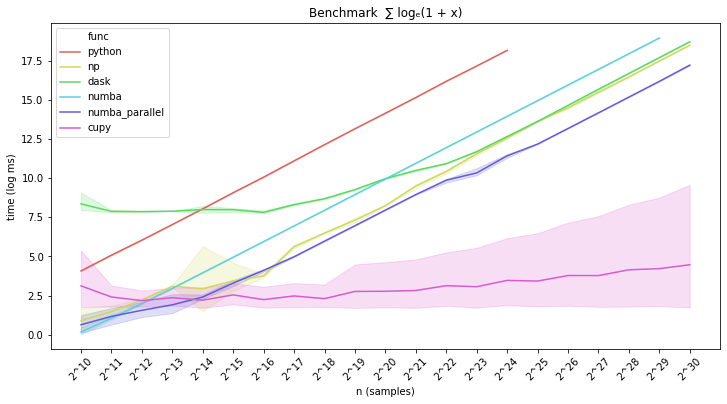

In [7]:
x, y, hue = "n (samples)", "time (log ms)", "func"
ax = sns.lineplot(x=x, y=y, data=pdf, sort=False, hue=hue, palette=sel_palette(pdf, hue), estimator=e)
[tick.set_rotation(45) for tick in ax.get_xticklabels()]
ax.figure.set_size_inches(12, 6)
_ = ax.set_title("Benchmark  ∑ logₑ(1 + x)")
_ = plt.show()

##### Absolute time

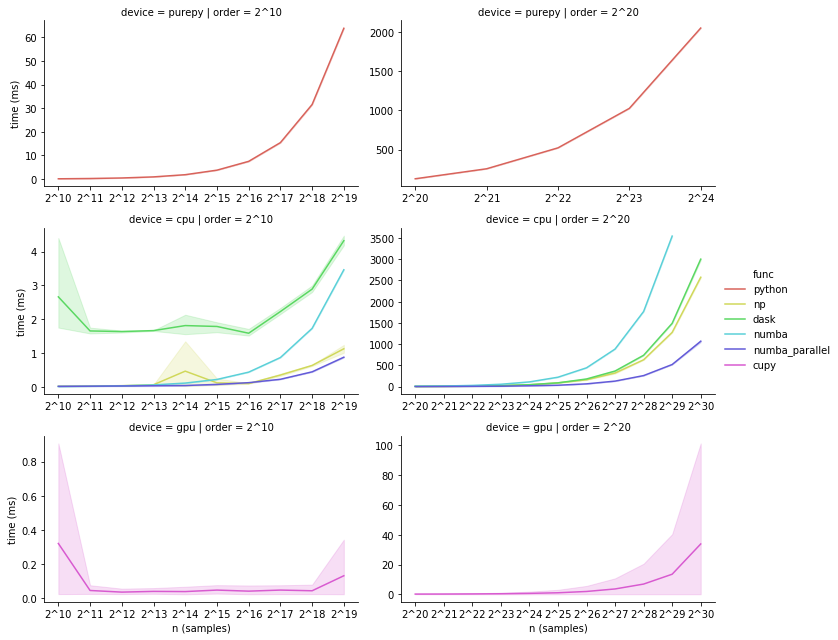

In [13]:
fmt = {"hue": "func", "col": "order", "row": "device", "height": 3, "aspect": 1.7}
p = sel_palette(df, fmt["hue"])

df.order = df.order.apply(lambda x: x.replace("2^30", "2^20"))
facet = sns.relplot(
    y="time (ms)", x="n (samples)", data=df, **fmt,
    kind="line", sort=False, palette=p, estimator="mean", facet_kws={"sharey": False, "sharex": False}, 
)

It's difficult to saturate the GPU with this operation. The variance increases with a noticeable impact on device memory above 10M samples.

However the min time is no different than at 1K samples, as the only bottleneck appears to be interdevice communication and/or python function overhead.

### Convolution

In [2]:
from scipy.signal import windows, fftconvolve

def padlr(pad: float):
    return (math.ceil(pad), math.floor(pad))

##### Time Domain

In [3]:
@nb.njit(parallel=True, fastmath=True)
def pconvolve(sig, win):
    m, n = win.size, sig.size
    conv = np.zeros(n)
    for t in nb.prange(m, n):
        conv[t] = (win * sig[t - m : t]).sum()
    return conv[m:] / win.sum()


def convolve(sig, win):
    psig = np.pad(sig, padlr(win.size / 2), "constant")
    return pconvolve(psig, win)


def convolve_np(sig, win):
    return np.convolve(sig, win, mode='same') / win.sum()


def square_and_hann(s: int = 100):
    win = windows.hann(s // 4)
    sig = np.repeat([0., 1., 0.], s)
    psig = np.pad(sig, padlr(win.size / 2), "constant")
    return (
        win, sig, psig,
        cp.asarray(win, dtype="float32"),
        cp.asarray(sig, dtype="float32"),
    )

##### Frequency Domain

In [6]:
def convolve_fft_scipy(sig, win):
    return fftconvolve(sig, win, mode="same") / win.sum()


def convolve_fft_cust(sig, win):
    pwin = np.pad(win, padlr((sig.size - win.size) / 2), mode="constant")
    fwin = np.fft.fft(pwin)
    fsig = np.fft.fft(sig)
    c = np.fft.ifft(fwin * fsig)
    return np.real(np.fft.fftshift(c)) / win.sum()


funcs = [f.__name__ for f in [pconvolve, convolve_np, convolve_fft_scipy, convolve_fft_cust]]


if cp is not np:
    def convolve_fft_gpu(sig, win):
        pwin = cp.pad(win, padlr((sig.size - win.size) / 2), mode="constant").astype(cp.float32)
        fwin = cp.fft.fft(pwin)
        fsig = cp.fft.fft(sig)
        c = cp.fft.ifft(fwin * fsig)
        return cp.real(cp.fft.fftshift(c)) / win.sum()
    
    funcs.append(convolve_fft_gpu.__name__)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

win, sig, psig, cpwin, cpsig = square_and_hann(2 ** 10)
cnp = convolve_np(sig, win)
c = convolve(sig, win)
pc = pconvolve(psig, win)
fc = convolve_fft_cust(sig, win)
fcs = convolve_fft_scipy(sig, win)
if cp is not np:
    fcg = convolve_fft_gpu(cpsig, cpwin)

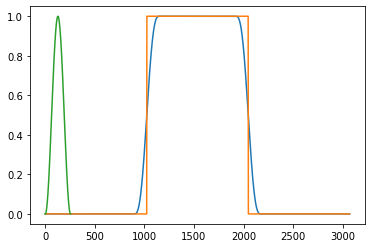

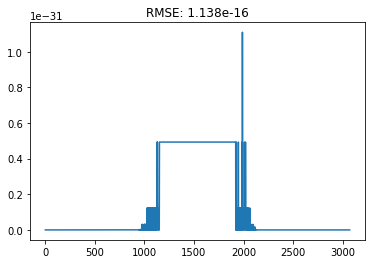

In [8]:
assert pc.shape == c.shape == cnp.shape == fc.shape == fcs.shape
if cp is not np:
     assert cnp.shape == fcg.shape
ax = sns.lineplot(data=pc)
ax = sns.lineplot(data=sig)
ax = sns.lineplot(data=win)
plt.show()

mse = np.square(cnp - pc)
rmse = np.sqrt(mse.sum() / mse.size)
ax = sns.lineplot(data=mse)
_ = ax.set_title(f"RMSE: {rmse:.4}")
plt.show()

#### Time by sample sizes

In [11]:
from timeit import repeat
from tqdm import tqdm

args = {"repeat": 5, "number": 1, "globals": globals()}
results = defaultdict(list)
sel_sig = lambda f: ('psig', 'win') if f == 'pconvolve' else ('cpsig', 'cpwin') if 'gpu' in f else ('sig', 'win')
stop = defaultdict(bool)
stop_th = 2.0  # seconds


for n in tqdm(logrange(2 ** 7, 2 ** 25)):
    win, sig, psig, cpwin, cpsig = square_and_hann(n)
    for f in funcs:
        results["n"] += [n for _ in range(args["repeat"])]
        results["iter"] += [i for i in range(args["repeat"])]
        results["func"] += [f for _ in range(args["repeat"])]
        results["device"] += ["gpu" if "gpu" in f else "cpu" for _ in range(args["repeat"])]
        results["order"] += [order_n(n) for _ in range(args["repeat"])]
        if stop[f]:
            results["time"] += [np.inf for _ in range(args["repeat"])]
        else:
            r = repeat(f"{f}({sel_sig(f)[0]}, {sel_sig(f)[1]})", **args)
            results["time"] += r
            if r[0] > stop_th:
                stop[f] = True

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [01:51<00:00, 12.66s/it]


##### Log2 time

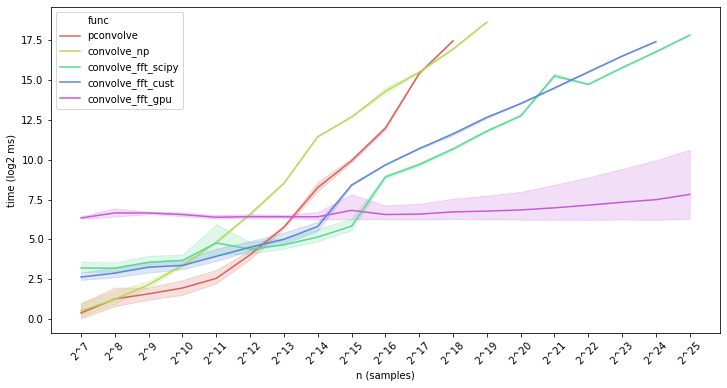

In [13]:
import pandas as pd
sel_palette = lambda df, c: sns.color_palette("hls", df[c].nunique(), desat=0.95)
ncol = "n (samples)"
size = (12, 6)
e = "mean"

df = pd.DataFrame(results)
df[ncol] = [n2pow(n) for n in df.n]
df["time (log2 ms)"] = np.log2(100 * df.time)
df["time (log2 ms)"] += np.abs(df["time (log2 ms)"].min())
df.time = 100 * df.time
df["domain"] = df.func.apply(lambda f: "freq" if "fft" in f else "time")
df = df.rename(columns={"time": "time (ms)"})

hue = "func"
p = sel_palette(df, hue)
ax = sns.lineplot(y="time (log2 ms)", x=ncol, data=df, hue=hue, sort=False, palette=p, estimator=e)
[tick.set_rotation(45) for tick in ax.get_xticklabels()]
ax.figure.set_size_inches(size)

##### Absolute time

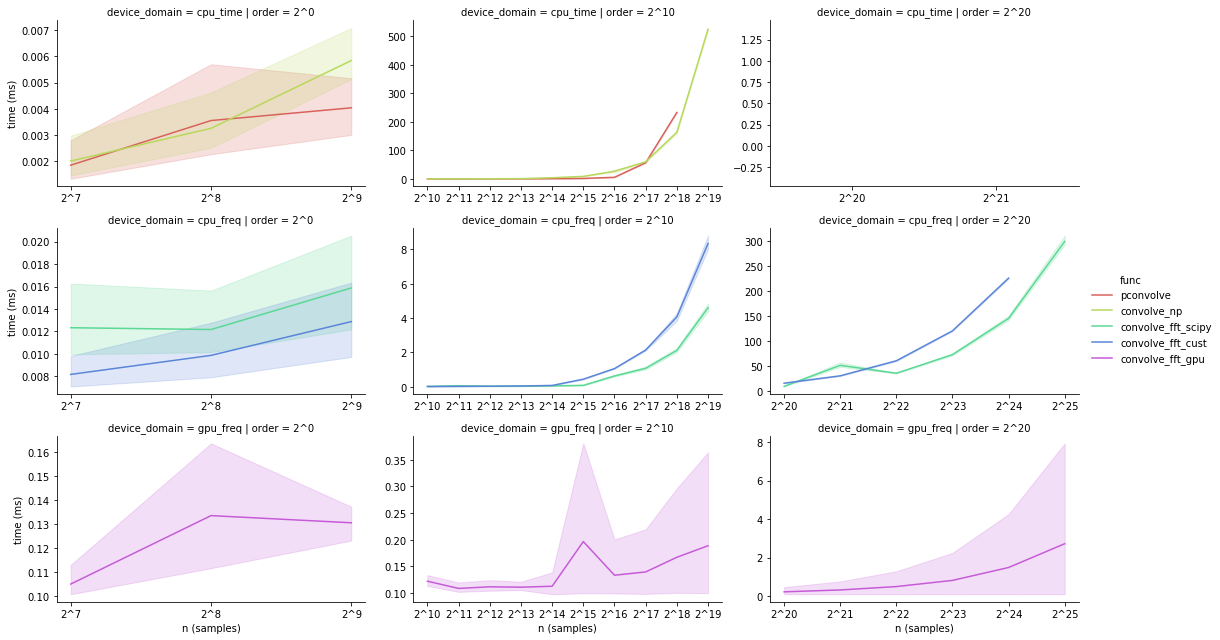

In [14]:
df["device_domain"] = df.device + "_" + df.domain
fmt = {"hue": "func", "col": "order", "row": "device_domain", "height": 3, "aspect": 1.7}
p = sel_palette(df, fmt["hue"])

facet = sns.relplot(
    y="time (ms)", x="n (samples)", data=df, **fmt,
    kind="line", sort=False, palette=p, estimator=e, facet_kws={"sharey": False, "sharex": False}, 
)

The numba parallel method `pconvolve` stops scaling well past a certain `n`. I'm not sure what the reason is, but likely one of the operations stops scaling well -- maybe the pad or the slicing.

The FFT methods begin to be cost efficient above 4096 samples. The GPU FFT method is difficult to saturate (time is constant) and has the best time above 64k samples. Likely due to the overhead of memory operations vs. compute time.

The GPU FFT performs significantly better when `n` is a power of 2. When not a power of 2, it performs on par with the scipy builtin.